In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [4]:
import numpy as np
import tensorflow as tf

In [7]:
data_tagged = pd.read_csv("../Alec_repo/data/cleaned_data/dataset_4.csv")
data_tagged = data_tagged.iloc[:, 1:]
data_tagged.head()

,cases,deaths,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density,county_population
0,0.0,0.0,0,76,5.0,7.0,15.164875,0.0,-4.0,-0.533183,141.59,92.423365,55869
1,0.0,0.0,1,76,0.0,1.0,-23.000000,0.0,-4.0,-0.621118,104.81,92.423365,55869
2,0.0,0.0,2,76,8.0,0.0,24.079480,0.0,-27.0,5.000000,130.58,92.423365,55869
3,0.0,0.0,3,76,-2.0,0.0,4.451923,0.0,2.0,0.000000,109.61,92.423365,55869
4,0.0,0.0,4,76,-2.0,0.0,7.138927,0.0,2.0,0.000000,119.56,92.423365,55869


In [8]:
data_tagged.replace([np.inf, -np.inf], np.nan, inplace=True)
data_tagged.dropna(inplace=True)
data_tagged_scaled = (data_tagged - data_tagged.min()) / (data_tagged.max() - data_tagged.min())

In [9]:
data_by_county = dict(iter(data_tagged_scaled.groupby('county')))

In [65]:
def build_dataset(dataset, observation_period=21, days_in_future=7):
    all_observations = []
    all_targets = []
    eligible_counties = {}
    min_observation_length = 9999
    for e, (k, v) in enumerate(dataset.items()):
        observation_length = len(v)
        #if observation_length < 4 * observation_period + days_in_future + 1:
        if observation_length < 2 * observation_period + days_in_future + 1:
            continue
        if observation_length < min_observation_length:
            min_observation_length = observation_length
        eligible_counties[e] = v
    
    start_index = observation_period
    end_index = min_observation_length - days_in_future + 1

    for i in range(start_index, end_index):
        all_county_observations = []
        all_county_targets = []
        for eligible_county, eligible_data in eligible_counties.items():
            eligible_targets = pd.concat([eligible_data["cases"], eligible_data["deaths"]], axis=1)
            eligible_observations = eligible_data.drop(["county", "date"], axis=1)
            
            indices = range(i - observation_period, i)
            
            observation_series = eligible_observations.iloc[indices, :].values.flatten()
            all_county_observations.append(observation_series)
            
            target_series = eligible_targets.iloc[i:i+days_in_future, :].values.flatten('F')
            all_county_targets.append(target_series)
            
        all_county_observations = np.array(all_county_observations)
        all_observations.append(all_county_observations)
        
        all_county_targets = np.array(all_county_targets).flatten()
        all_targets.append(all_county_targets)
        
    return np.array(all_observations), np.array(all_targets)

In [66]:
eligible_observations, eligible_targets = build_dataset(data_by_county)

In [67]:
def shuffle_eligible_data(observations, targets, training_percentage=0.8):
    complete_set = list(zip(observations, targets))
    random.shuffle(complete_set)
    shuffled_observations, shuffled_targets = zip(*complete_set)
    boundary = int(len(targets) * training_percentage)
    return (np.array(shuffled_observations[:boundary]),
            np.array(shuffled_targets[:boundary]), 
            np.array(shuffled_observations[boundary:]), 
            np.array(shuffled_targets[boundary:]))

In [68]:
e_training_obs, e_training_tar, e_testing_obs, e_testing_tar = shuffle_eligible_data(eligible_observations, eligible_targets)

In [115]:
print ('Shape of observation period : {}'.format(e_training_obs[0].shape))
print ('\n Shape of target : {}'.format(e_training_tar[0].shape))

Shape of observation period : (1954, 231)

 Shape of target : (27356,)


In [70]:
BATCH_SIZE = 1

e_training = tf.data.Dataset.from_tensor_slices((e_training_obs, e_training_tar))
e_training = e_training.shuffle(99999).batch(BATCH_SIZE).repeat()

e_testing = tf.data.Dataset.from_tensor_slices((e_testing_obs, e_testing_tar))
e_testing = e_testing.shuffle(99999).batch(BATCH_SIZE)

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=eligible_observations.shape[-2:], activation='relu'))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(28084))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

In [18]:
EPOCHS = 3
EVALUATION_INTERVAL = 200

model_history = model.fit(e_training, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/3
200/200 [==============================] - 866s 4s/step - loss: 8.2320e-04
Epoch 2/3
200/200 [==============================] - 848s 4s/step - loss: 4.1170e-04
Epoch 3/3
200/200 [==============================] - 853s 4s/step - loss: 3.6515e-04


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2006, 128)         184320    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2006, 128)         131584    
_________________________________________________________________
dense (Dense)                (None, 2006, 28084)       3622836   
Total params: 3,938,740
Trainable params: 3,938,740
Non-trainable params: 0
_________________________________________________________________


In [22]:
def rescale_e_values(category, values):
    scaled_values = data_tagged[category].min() + ((data_tagged[category].max() - data_tagged[category].min()) * values)
    return scaled_values

def create_time_steps(length):
    return list(range(-length, 0))

    
for x, y in e_testing.take(15):
    prediction = model(x)[0]
    all_targets = y[0]
    
    cpc_prediction = []
    cpc_target = []
    for i in range(0, len(prediction), 14):
        rescaled_predictions = rescale_e_values("cases", prediction[i:i+7])
        rescaled_targets = rescale_e_values("cases", all_targets[i:i+7])
        cpc_prediction.append(rescaled_predictions)
        cpc_target.append(rescaled_targets)
        
    cpc_history = []
    for county_observation in x[0]:
        # from 1 for deaths
        cpc_history_rescaled = rescale_e_values("cases", county_observation[0::11])
        cpc_history.append(cpc_history_rescaled)

    time_before = create_time_steps(cpc_history[0].shape[0])
    
    selector = np.arange(2006)
    np.random.shuffle(selector)
    selector = selector[:10]
    cpc_pred_plot = np.array(cpc_prediction)[selector]
    cpc_target_plot = np.array(cpc_target)[selector]
    relevant_history = np.array(cpc_history)[selector]

    plt.figure(figsize=(12, 6))
    for i in range(len(cpc_pred_plot)):
        time_after = np.arange(len(cpc_pred_plot[i]))
        plt.plot(time_before, relevant_history[i], 'g-', label='History')
        plt.plot(time_after, cpc_pred_plot[i], 'b-', label='Prediction')
        plt.plot(time_after, cpc_target_plot[i], 'r-', label='Target')
        plt.legend(loc='upper left')
        plt.title(f'County {selector[i]}')
        print(relevant_history[i])
        print(cpc_target_plot[i])
        plt.show()
    
#     plt.figure(figsize=(12, 6))
#     for e, (prediction, target) in enumerate(zip(cpc_prediction, cpc_target)):
#         history = cpc_history[e]
#         time_after = np.arange(len(prediction))
#         plt.plot(time_before, history, 'g-', label='History')
#         plt.plot(time_after, prediction, 'b-', label='Prediction')
#         plt.plot(time_after, target, 'r-', label='Target')
#         plt.legend(loc='upper left')
#         plt.title(f'County {e}')
#         plt.show()
#         break

IndexError: index 1197 is out of bounds for axis 0 with size 144

In [524]:
#model.save('./models/all_counties_correct')

INFO:tensorflow:Assets written to: ./models/all_counties_correct\assets


In [528]:
losses = []
for x, y in e_testing.take(-1):
    prediction = model(x)[0]
    all_target = y[0]
    
    cpc_prediction = []
    cpc_target = []
    
    for i in range(0, len(prediction), 14):
        rescaled_predictions = rescale_e_values("cases", prediction[i:i+7])
        rescaled_targets = rescale_e_values("cases", all_targets[i:i+7])
        loss = tf.keras.losses.MSE(rescaled_targets, rescaled_predictions)
        losses.append(loss)
print(len(losses))

10030


In [529]:
print(np.sqrt(sum(losses) / len(losses)))

tf.Tensor(13479.201, shape=(), dtype=float32)


In [10]:
def build_dataset_cases(dataset, observation_period=21, days_in_future=7):
    all_observations = []
    all_targets = []
    eligible_counties = {}
    min_observation_length = 9999
    for e, (k, v) in enumerate(dataset.items()):
        observation_length = len(v)
        if observation_length < 2 * observation_period + days_in_future + 1:
            continue
        if observation_length < min_observation_length:
            min_observation_length = observation_length
        eligible_counties[e] = v
    
    start_index = observation_period
    end_index = min_observation_length - days_in_future + 1

    for i in range(start_index, end_index):
        all_county_observations = []
        all_county_targets = []
        for eligible_county, eligible_data in eligible_counties.items():
            eligible_targets = eligible_data["cases"]
            eligible_observations = eligible_data.drop(["county", "date"], axis=1)
            
            indices = range(i - observation_period, i)
            
            observation_series = eligible_observations.iloc[indices, :].values.flatten()
            all_county_observations.append(observation_series)
            
            target_series = eligible_targets.iloc[i:i+days_in_future].values
            all_county_targets.append(target_series)
            
        all_county_observations = np.array(all_county_observations)
        all_observations.append(all_county_observations)
        
        all_county_targets = np.array(all_county_targets).flatten()
        all_targets.append(all_county_targets)
        
    return np.array(all_observations), np.array(all_targets)

In [19]:
just_cases_obs, just_cases_tar = build_dataset_cases(data_by_county, observation_period=7, days_in_future=3)

In [20]:
jc_training_obs, jc_training_tar, jc_testing_obs, jc_testing_tar = shuffle_eligible_data(just_cases_obs, just_cases_tar)

In [21]:
print ('Single window of past history : {}'.format(jc_training_obs[0].shape))
print ('\n Target temperature to predict : {}'.format(jc_training_tar[0].shape))

Single window of past history : (2009, 77)

 Target temperature to predict : (6027,)


In [22]:
BATCH_SIZE = 1

cases_training = tf.data.Dataset.from_tensor_slices((jc_training_obs, jc_training_tar))
cases_training = cases_training.shuffle(99999).batch(BATCH_SIZE).repeat()

cases_testing = tf.data.Dataset.from_tensor_slices((jc_testing_obs, jc_testing_tar))
cases_testing = cases_training.shuffle(99999).batch(BATCH_SIZE)

In [25]:
model_jc = tf.keras.models.Sequential()
model_jc.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=just_cases_obs.shape[-2:], activation='relu'))
model_jc.add(tf.keras.layers.LSTM(64, activation='relu'))
model_jc.add(tf.keras.layers.Dense(6027))

model_jc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

In [ ]:
EPOCHS = 3
EVALUATION_INTERVAL = 200

model_history_js = model_jc.fit(cases_training, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)

In [5]:
saved_model = tf.keras.models.load_model('./models/all_counties_correct')

In [75]:
model_test = tf.keras.models.Sequential()
model_test.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=eligible_observations.shape[-2:], activation='relu'))
model_test.add(tf.keras.layers.LSTM(128, activation='relu'))
model_test.add(tf.keras.layers.Dense(27356))

model_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

In [76]:
model_test.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1954, 128)         184320    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 27356)             3528924   
Total params: 3,844,828
Trainable params: 3,844,828
Non-trainable params: 0
_________________________________________________________________


In [77]:
EPOCHS = 3
EVALUATION_INTERVAL = 200

model_history_test = model_test.fit(e_training, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/3
200/200 [==============================] - 514s 3s/step - loss: 0.0028
Epoch 2/3
200/200 [==============================] - 491s 2s/step - loss: 0.0019
Epoch 3/3
200/200 [==============================] - 525s 3s/step - loss: 0.0013


In [78]:
san_francisco = 881549
new_york = 1628706
orange_county = 1393452
miami = 2716940
boston = 803907
cities_of_interest = {
    san_francisco: 'San Francisco',
    new_york: 'New York',
    orange_county: 'Orange County FL',
    miami: 'Miami',
    boston: 'Boston'
}

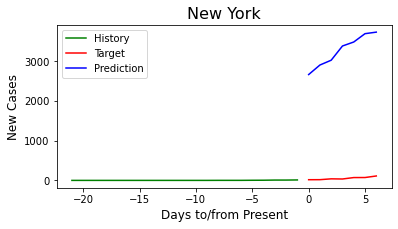

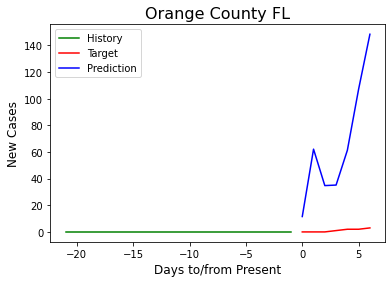

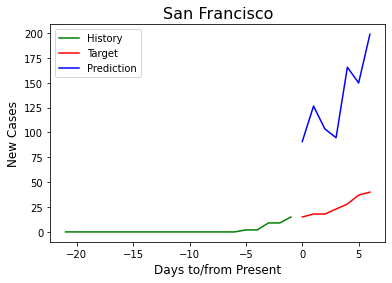

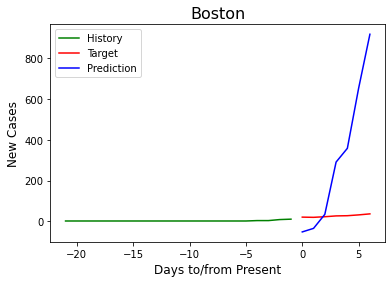

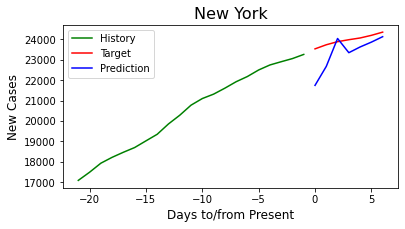

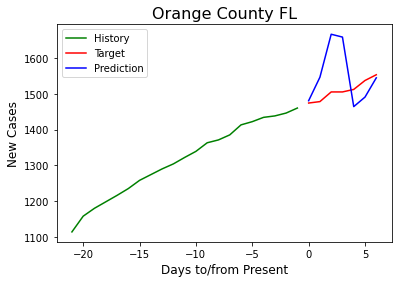

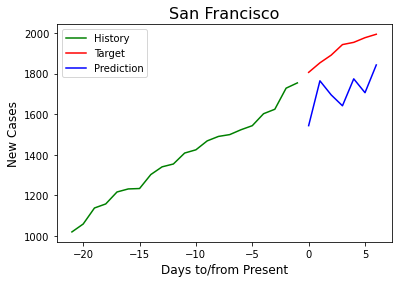

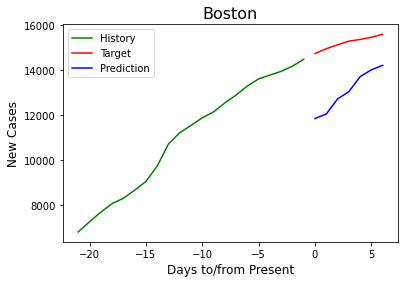

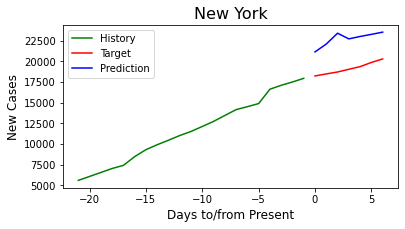

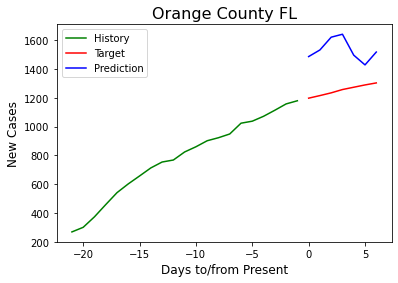

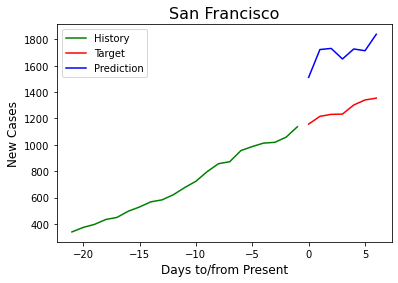

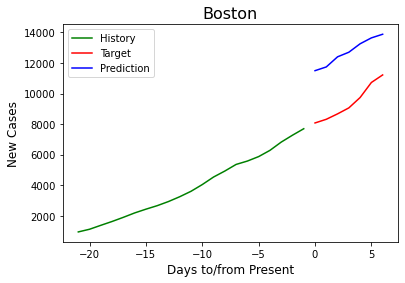

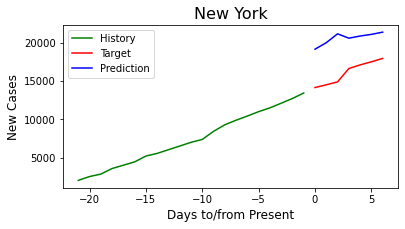

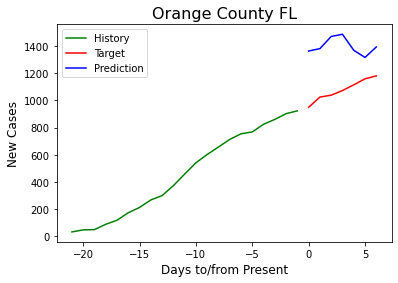

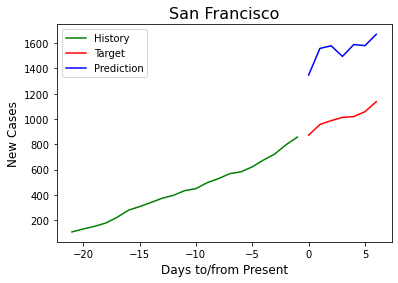

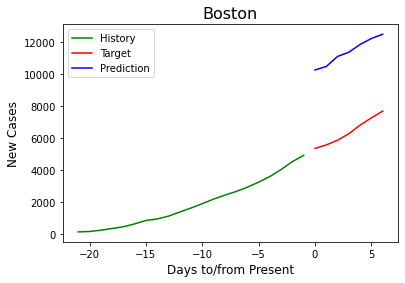

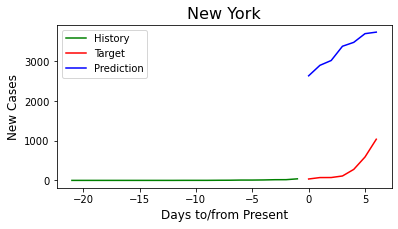

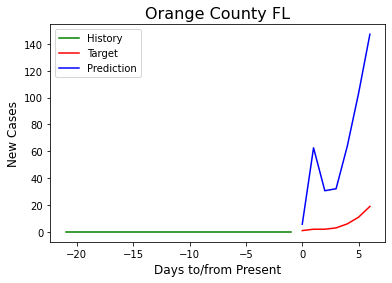

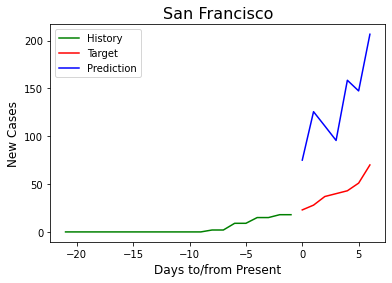

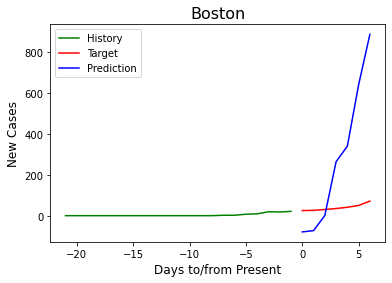

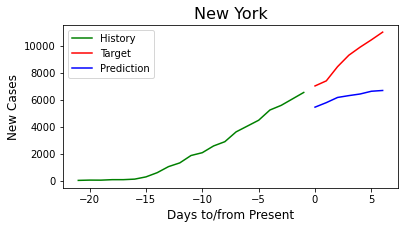

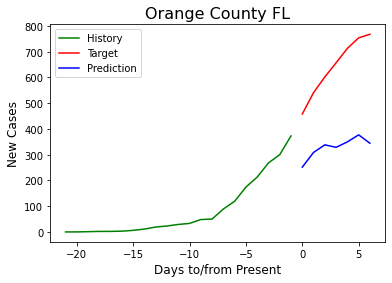

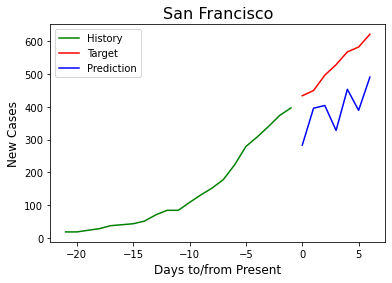

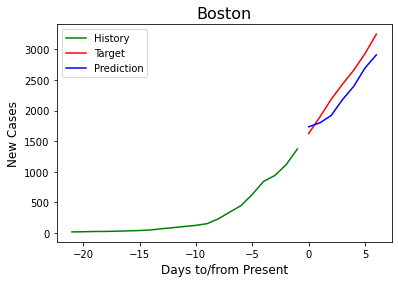

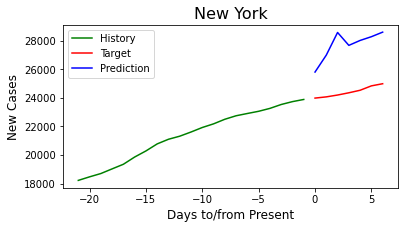

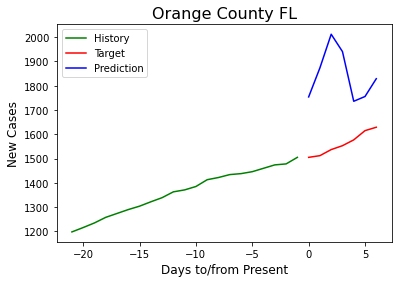

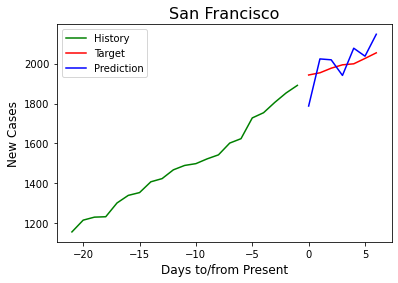

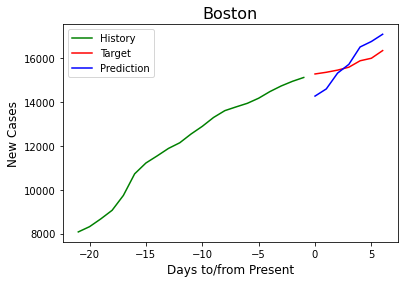

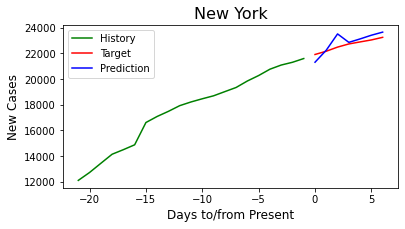

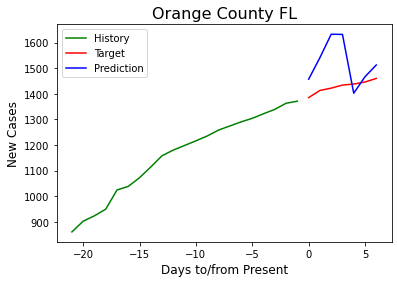

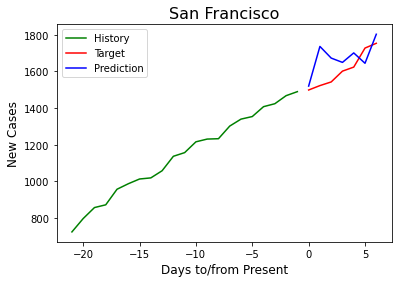

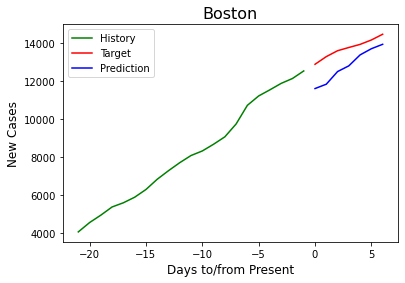

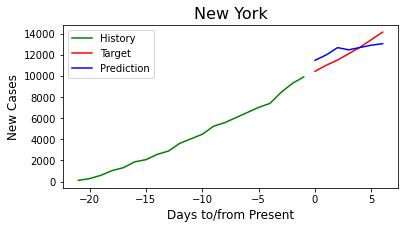

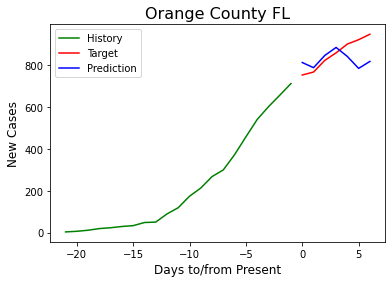

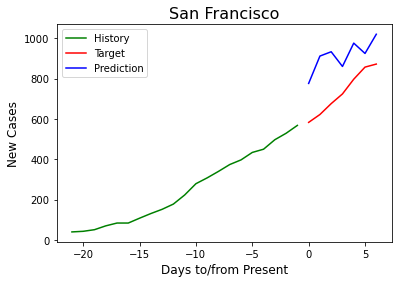

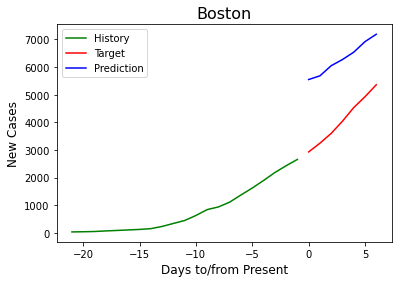

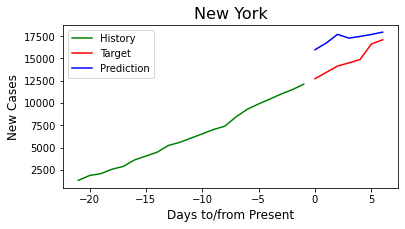

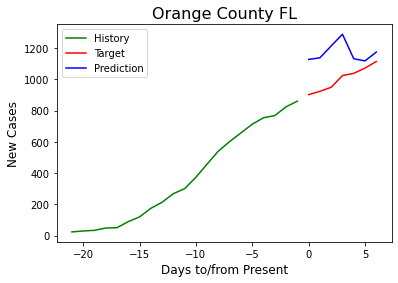

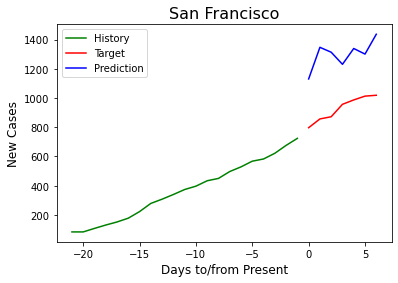

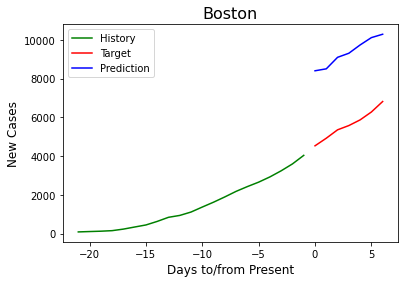

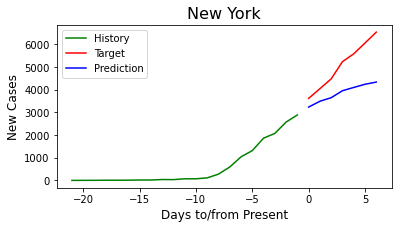

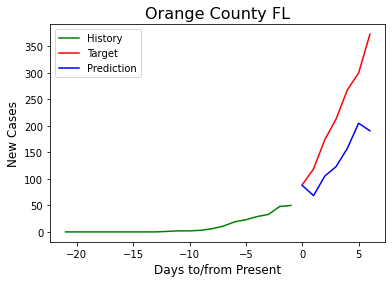

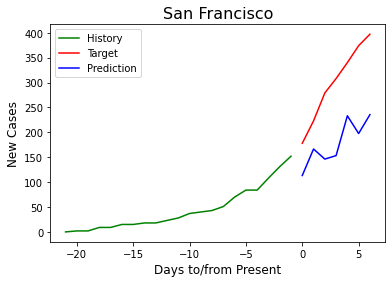

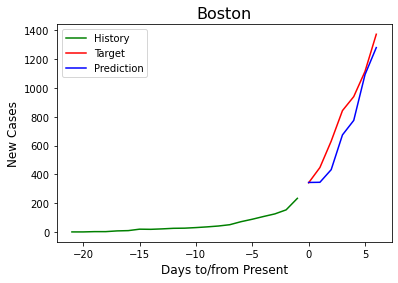

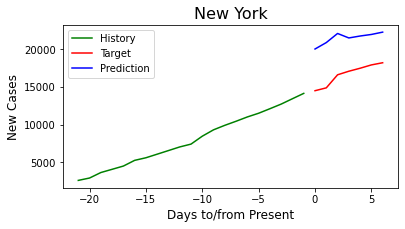

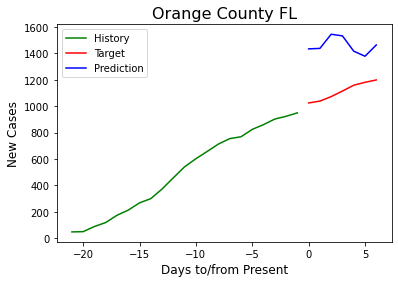

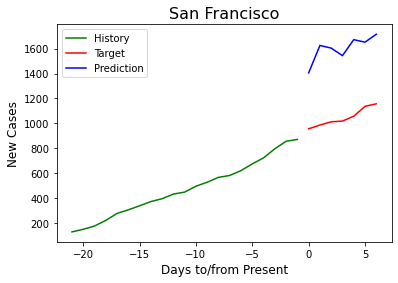

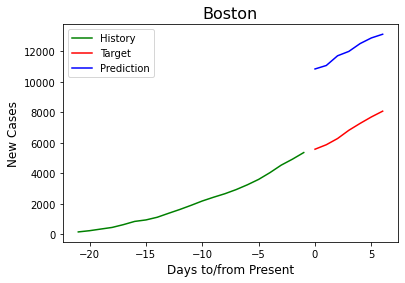

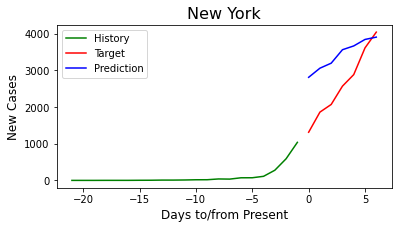

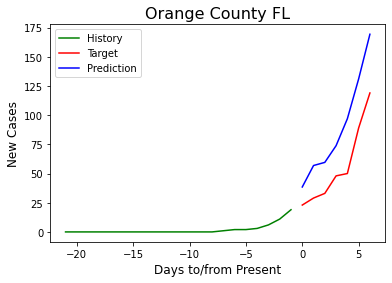

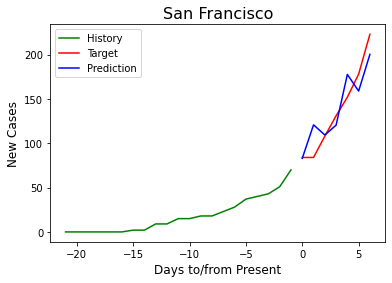

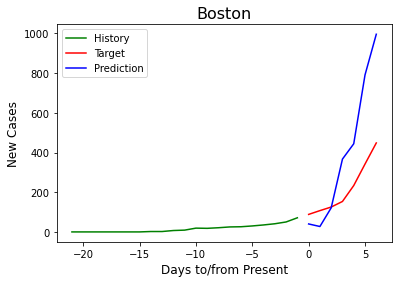

In [93]:
for iterator, (x, y) in enumerate(e_testing.take(-1)):
    prediction = model_test(x)[0]
    prediction_reshaped = np.reshape(prediction, (-1, 14))
    all_targets = y[0]
    all_targets_reshaped = np.reshape(all_targets, (-1, 14))
    
    histories_plot = []
    predictions_plot = []
    targets_plot = []
    labels = []
    for e, county_observation in enumerate(x[0]):
        county_pop = int(rescale_e_values("county_population", county_observation[10]))
        if county_pop in cities_of_interest.keys():
            history = rescale_e_values("cases", county_observation[0::11])
            histories_plot.append(history)
            
            county_prediction = rescale_e_values("cases", prediction_reshaped[e][:7])
            predictions_plot.append(county_prediction)
            
            county_target = rescale_e_values("cases", all_targets_reshaped[e][:7])
            targets_plot.append(county_target)
            
            labels.append(cities_of_interest[county_pop])
        continue
    
    plt.figure(figsize=(6, 3))
    for i in range(len(labels)):
        time_before = create_time_steps(len(histories_plot[i]))
        time_after = np.arange(len(predictions_plot[i]))
        
        plt.plot(time_before, histories_plot[i], 'g-', label="History")
        plt.plot(time_after, targets_plot[i], 'r-', label="Target")
        plt.plot(time_after, predictions_plot[i], 'b-', label="Prediction")
        plt.xlabel("Days to/from Present", fontsize=12)
        plt.ylabel("New Cases", fontsize=12)
        plt.title(labels[i], fontsize=16)
        plt.legend(loc='upper left')
        folder_name = "".join(labels[i].split())
        plt.savefig(f"plots/{folder_name}/{iterator}.png", bbox_inches='tight')
        plt.show()
    
#     cpc_prediction = []
#     cpc_target = []
#     for i in range(0, len(prediction), 14):
#         rescaled_predictions = rescale_e_values("cases", prediction[i:i+7])
#         rescaled_targets = rescale_e_values("cases", all_targets[i:i+7])
#         cpc_prediction.append(rescaled_predictions)
#         cpc_target.append(rescaled_targets)
    
        
#     cpc_history = []
#     for county_observation in x[0]:
#         # from 1 for deaths
#         cpc_history_rescaled = rescale_e_values("cases", county_observation[0::11])
#         cpc_history.append(cpc_history_rescaled)

#     time_before = create_time_steps(cpc_history[0].shape[0])
    
#     selector = np.arange(2006)
#     np.random.shuffle(selector)
#     selector = selector[:10]
#     cpc_pred_plot = np.array(cpc_prediction)[selector]
#     cpc_target_plot = np.array(cpc_target)[selector]
#     relevant_history = np.array(cpc_history)[selector]

#     plt.figure(figsize=(12, 6))
#     for i in range(len(cpc_pred_plot)):
#         time_after = np.arange(len(cpc_pred_plot[i]))
#         plt.plot(time_before, relevant_history[i], 'g-', label='History')
#         plt.plot(time_after, cpc_pred_plot[i], 'b-', label='Prediction')
#         plt.plot(time_after, cpc_target_plot[i], 'r-', label='Target')
#         plt.legend(loc='upper left')
#         plt.title(f'County {selector[i]}')
#         print(relevant_history[i])
#         print(cpc_target_plot[i])
#         plt.show()
    
#     plt.figure(figsize=(12, 6))
#     for e, (prediction, target) in enumerate(zip(cpc_prediction, cpc_target)):
#         history = cpc_history[e]
#         time_after = np.arange(len(prediction))
#         plt.plot(time_before, history, 'g-', label='History')
#         plt.plot(time_after, prediction, 'b-', label='Prediction')
#         plt.plot(time_after, target, 'r-', label='Target')
#         plt.legend(loc='upper left')
#         plt.title(f'County {e}')
#         plt.show()
#         break

In [110]:
# losses = {}
# for x, y in e_testing.take(-1):
#     prediction = model_test(x)[0]
#     prediction_reshaped = np.reshape(prediction, (-1, 14))
#     all_targets = y[0]
#     all_targets_reshaped = np.reshape(all_targets, (-1, 14))
    
#     for iterator, sample in enumerate(prediction_reshaped):
#         cases_hat = rescale_e_values("cases", sample[:7])
#         cases_true = rescale_e_values("cases", all_target_reshaped[iterator][:7])
#         loss = tf.keras.losses.MSE(cases_true, cases_hat)
#         loss = np.sqrt(loss)
#         if iterator in losses:
#             new_losses = losses[iterator].append(loss)
#         else:
#             losses[iterator] = [loss]

county_averages = []
for k, v in losses.items():
    county_averages.append(sum(v) / len(v))
    
print(min(county_averages), max(county_averages))
total_average_loss = sum(county_averages) / len(county_averages)
print(f'Average RMSE across all {len(county_averages)} eligible counties for all observation periods: {total_average_loss}')

21.941286673912636 16765.572359525242
Average RMSE across all 1954 eligible counties for all observation periods: 313.8159184944967


In [114]:
for i in range(len(county_averages)):
    county_pop = int(rescale_e_values("county_population", x[0][i][10]))
    if county_pop in cities_of_interest.keys():
        specific_loss = county_averages[i]
        print(f'Average loss in {cities_of_interest[county_pop]}: {specific_loss}')

Average loss in New York: 14516.79696890024
Average loss in Orange County FL: 925.9731803307167
Average loss in San Francisco: 1036.234890277569
Average loss in Boston: 7553.787381685697


In [85]:
#model_test.save('./models/all_counties_good_data')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/all_counties_good_data\assets


In [ ]:
# Above for use with
# def build_dataset(dataset, observation_period=21, days_in_future=7):
#     all_observations = []
#     all_targets = []
#     eligible_counties = {}
#     min_observation_length = 9999
#     for e, (k, v) in enumerate(dataset.items()):
#         observation_length = len(v)
#         # if observation_length < 2 * observation_period + days_in_future + 1:
#         if observation_length < 4 * observation_period + days_in_future + 1:
#             continue
#         if observation_length < min_observation_length:
#             min_observation_length = observation_length
#         eligible_counties[e] = v
    
#     start_index = observation_period
#     end_index = min_observation_length - days_in_future + 1

#     for i in range(start_index, end_index):
#         all_county_observations = []
#         all_county_targets = []
#         for eligible_county, eligible_data in eligible_counties.items():
#             eligible_targets = pd.concat([eligible_data["cases"], eligible_data["deaths"]], axis=1)
#             eligible_observations = eligible_data.drop(["county", "date"], axis=1)
            
#             indices = range(i - observation_period, i)
            
#             observation_series = eligible_observations.iloc[indices, :].values.flatten()
#             all_county_observations.append(observation_series)
            
#             target_series = eligible_targets.iloc[i:i+days_in_future, :].values.flatten('F')
#             all_county_targets.append(target_series)
            
#         all_county_observations = np.array(all_county_observations)
#         all_observations.append(all_county_observations)
        
#         all_county_targets = np.array(all_county_targets).flatten()
#         all_targets.append(all_county_targets)
        
#     return np.array(all_observations), np.array(all_targets)